# Final Project - Hillary Clinton Emails

## Team Members

*Simon Ustoyev

*Elina Azrilyan

*Jack Russo

*Anil Akyildirim

## Introduction

In our Final Project, we decided perform exploratory analysis on Hillary Clinton's email dataset, including network analysis between the email exchanges between contacts to define centrality measures on contacts, sentiment analysis on the Subject and Body Text leveraging NLTK. Based on our analysis, our goal is to see important connections she has and most used words on Subjects and Body Text of the emails along with Topic Categories. 

## About the Data

Hillary Clinton's email documents were released by the State Department as PDFs and Kaggle cleaned and normalized these document and released for public analysis. The data set can be found here: https://www.kaggle.com/kaggle/hillary-clinton-emails 

The dataset provided has 4 csv files, Aliases.csv which gives us the unique identifier of the internal reference, Alias (text in the From/To field that refers to the person and Person ID. EmailReceivers.csv also includes unique identifier for internal reference along with the id of the email. Emails gives us the From / To information, Subject Text, Body Text and document number. Persons.cvs provides us the unique identifier and the name of the person.

[Assignment Video]()

In [44]:
# Load Packages
# we attempted to use variety of Topic Modeling incliding LDA
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from pylab import rcParams
import networkx.algorithms.bipartite as bi
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import plotly
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import wordcloud
import plotly.graph_objs as go
import string
import re
import nltk
import string
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk import RegexpTokenizer
from gensim.models import LsiModel
from gensim import matutils
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim
import plotly.io as pio
from IPython.display import Image

## Data Collection

We start with exploring EmailReceivers.csv to create a network analysis and look at the relationship between the contacts.

In [45]:
# load the data
df = pd.read_csv("EmailReceivers.csv")
df.head()

Id  EmailId  PersonId
0   1        1        80
1   2        2        80
2   3        3       228
3   4        3        80
4   5        4        80

In [46]:
dfp = pd.read_csv("Persons.csv")
dfp.head()

Id                          Name
0   1                111th Congress
1   2  AGNA USEMB Kabul Afghanistan
2   3                            AP
3   4                      ASUNCION
4   5                          Alec

In [47]:
# Tail Emails DataFrame
df_emails = pd.read_csv("Emails.csv")
df_emails.tail()

Id  DocNumber             MetadataSubject MetadataTo  \
7940  7941  C05778462                       WYDEN          H   
7941  7942  C05778463                      SENATE          H   
7942  7943  C05778465               RICHARD (TNR)          H   
7943  7944  C05778466                       FROM           H   
7944  7945  C05778470  NOTE FOR SECRETARY CLINTON          H   

           MetadataFrom  SenderPersonId           MetadataDateSent  \
7940   Verma, Richard R           180.0  2010-12-16T05:00:00+00:00   
7941   Verma, Richard R           180.0  2010-12-16T05:00:00+00:00   
7942   Jiloty, Lauren C           116.0  2010-12-16T05:00:00+00:00   
7943           PVerveer           143.0  2012-12-17T05:00:00+00:00   
7944  Sullivan, Jacob J            87.0  2010-12-17T05:00:00+00:00   

           MetadataDateReleased  \
7940  2015-08-31T04:00:00+00:00   
7941  2015-08-31T04:00:00+00:00   
7942  2015-08-31T04:00:00+00:00   
7943  2015-08-31T04:00:00+00:00   
7944  2015-08-31T04:00:00+00:00   

                                        MetadataPdfLink MetadataCaseNumber  \
7940  DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...       F-2014-20439   
7941  DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...       F-2014-20439   
7942  DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...       F-2014-20439   
7943  DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...       F-2014-20439   
7944  DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...       F-2014-20439   

      ... ExtractedTo                             ExtractedFrom  \
7940  ...         NaN      Verma, Richard R <VermaRR@state.gov>   
7941  ...         NaN      Verma, Richard R <VermaRR@state.gov>   
7942  ...         NaN     Jiloty, Lauren C <JilotyLC@state.gov>   
7943  ...    PVervee,                                       NaN   
7944  ...         NaN  Sullivan, Jacob J <SullivanJJ@state.gov>   

                                           ExtractedCc  \
7940                                               NaN   
7941  Sullivan, Jacob J; Mills, Cheryl D; Abedin, Huma   
7942                                               NaN   
7943                                               NaN   
7944                                      Abedin, Huma   

                         ExtractedDateSent ExtractedCaseNumber  \
7940   Thursday, December 16, 2010 7:41 PM        F-2014-20439   
7941   Thursday, December 16, 2010 8:09 PM        F-2014-20439   
7942  Thursday, December 16, 2010 10:52 PM        F-2014-20439   
7943                             12/14/201        F-2014-20439   
7944    Friday, December 17, 2010 10:42 AM        F-2014-20439   

     ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
7940          C05778462            08/31/2015              RELEASE IN PART   
7941          C05778463            08/31/2015              RELEASE IN FULL   
7942          C05778465            08/31/2015              RELEASE IN PART   
7943          C05778466            08/31/2015              RELEASE IN PART   
7944          C05778470            08/31/2015              RELEASE IN FULL   

                                      ExtractedBodyText  \
7940                                                NaN   
7941  Big change of plans in the Senate. Senator Rei...   
7942                                                NaN   
7943  PVerveer B6\nFriday, December 17, 2010 12:12 A...   
7944                                         See below.   

                                                RawText  
7940  UNCLASSIFIED U.S. Department of State Case No....  
7941  UNCLASSIFIED U.S. Department of State Case No....  
7942  UNCLASSIFIED U.S. Department of State Case No....  
7943  Hi dear Melanne and Alyse,\nHope this email re...  
7944  UNCLASSIFIED U.S. Department of State Case No....  

[5 rows x 22 columns]

## Data Exploration
We will do prelimary data exploration

In [48]:
# number of email receivers [affiliations]
print('Number of Email Receiver entries: ', len(df))

Number of Email Receiver entries:  9306


We see that the number of email receivers are 9,306

In [49]:
# data preperation for network analysis
df['EmailId'] = 'E' + df['EmailId'].astype(str) # Prepend EmailId with 'E'
df['PersonId'] = 'P' + df['PersonId'].astype(str) # Prepend PersonId with 'P'
df.head()

Id EmailId PersonId
0   1      E1      P80
1   2      E2      P80
2   3      E3     P228
3   4      E3      P80
4   5      E4      P80

In [50]:
# Creating Graph object
B = nx.from_pandas_edgelist(df, source='PersonId', target='EmailId')

# Check if Graph is 'bipartite'
bi.is_bipartite(B)

True

In [51]:
# Get list of "Person ID" nodes
idp = df['PersonId'].unique()

# Get list of "Email ID" nodes
ide = df['EmailId'].unique()

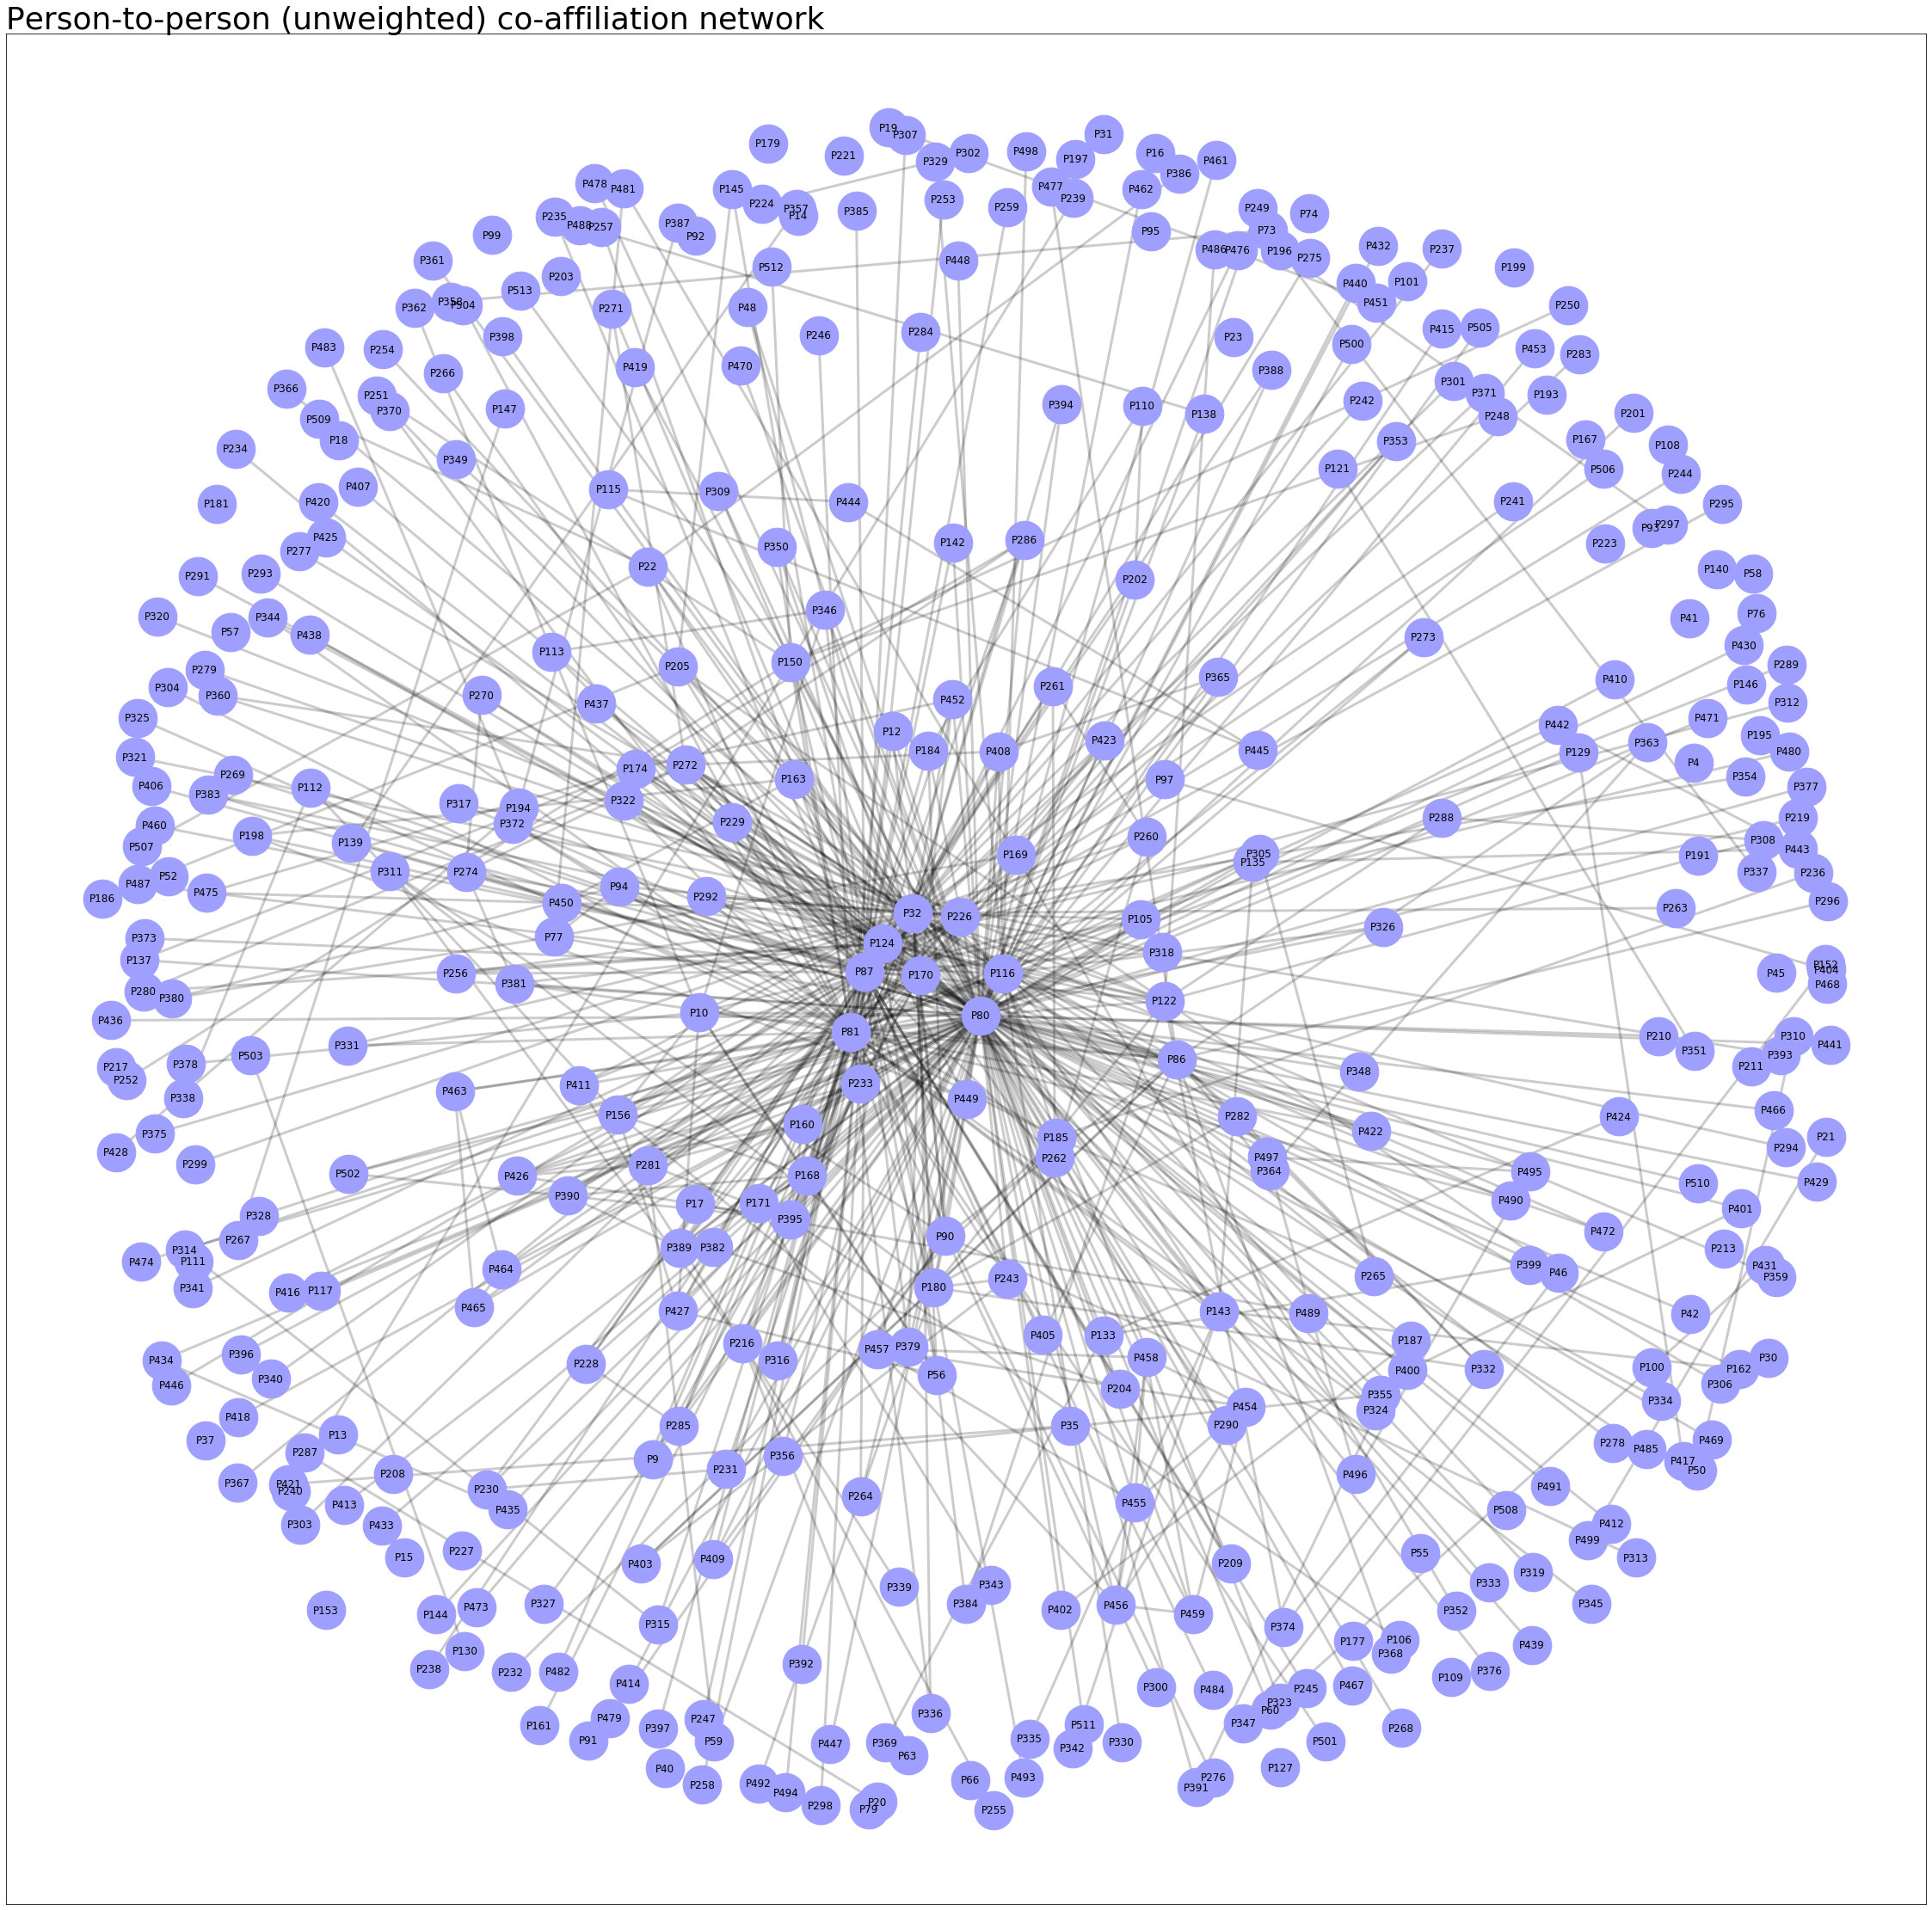

In [52]:
# Create and draw a projected graph for person-to-person network
pG = bi.projected_graph(B, idp)
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(pG, k = 0.5)
edg = nx.draw_networkx_edges(pG, pos, width = 3, alpha = 0.2)
pnd = nx.draw_networkx_nodes(pG, pos, node_color = "#9f9fff", node_size = 2000)
lbl = nx.draw_networkx_labels(pG, pos, font_size = 12)
ttl = plt.title('Person-to-person (unweighted) co-affiliation network', loc = 'left', fontsize = 36)

When we look at the person to person (unweighted) co-affiliation network. As expected, a lot of people connected in the middle, getting more and more less as the circle expands.

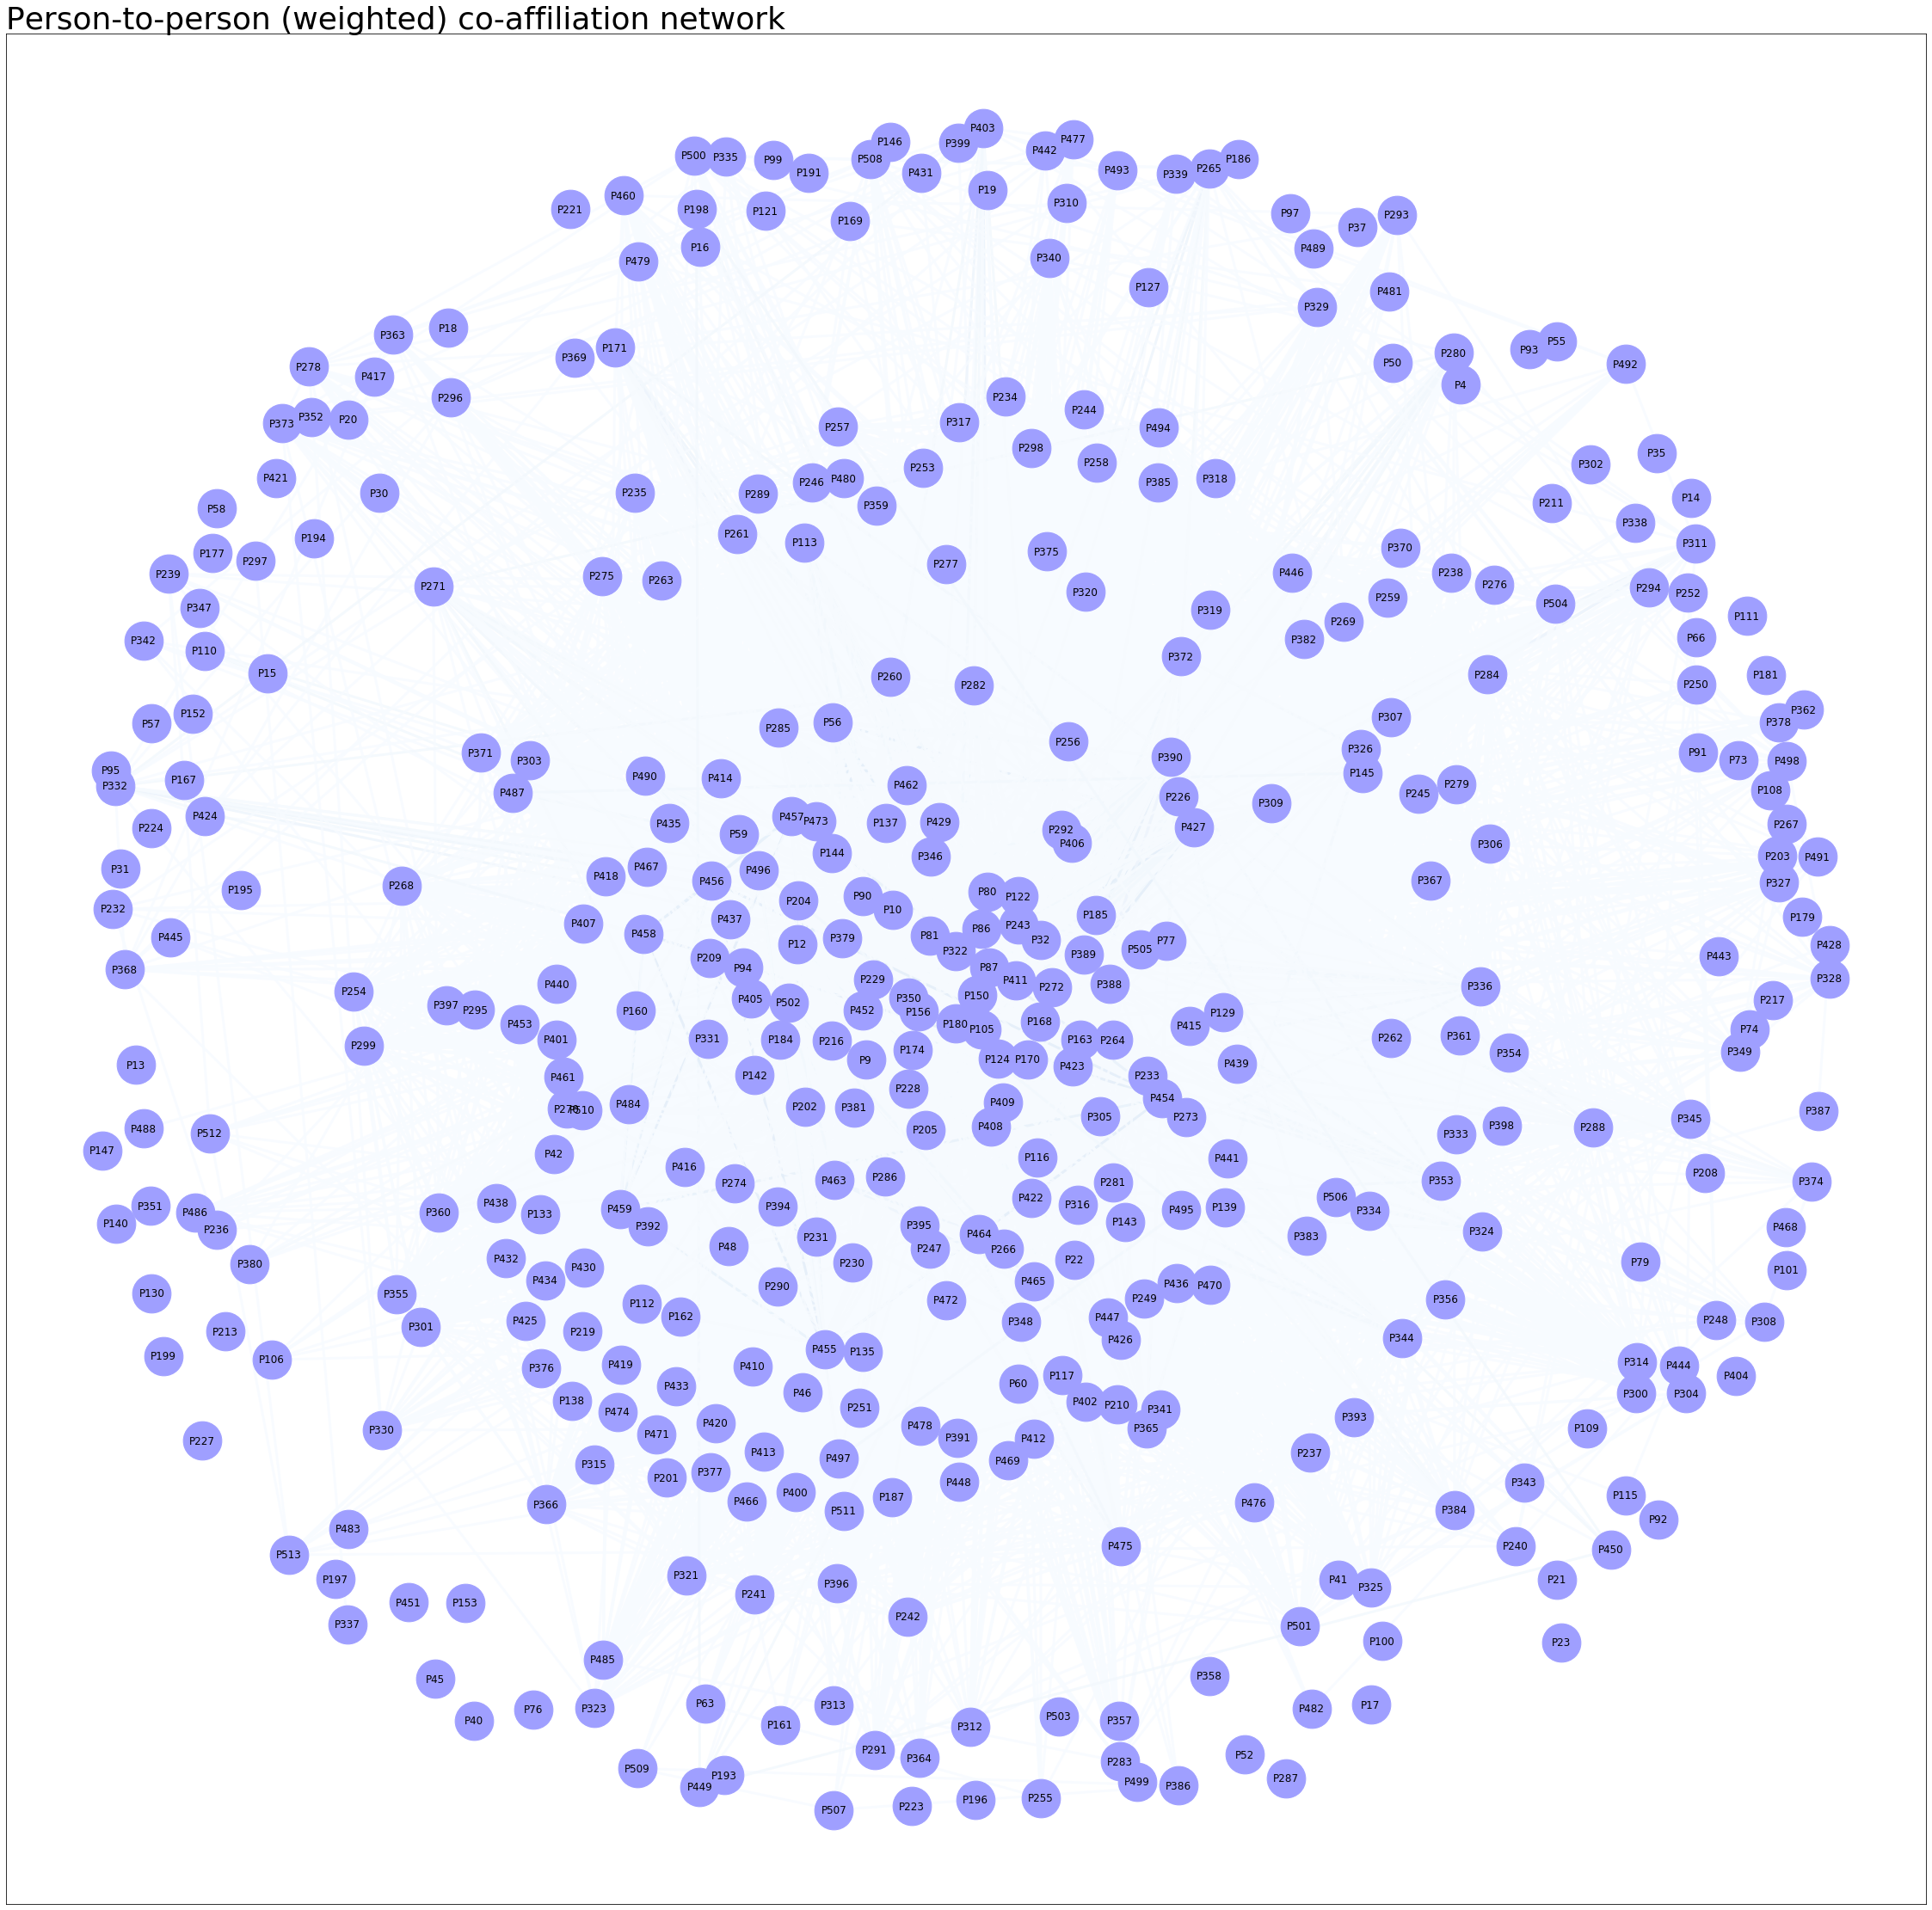

In [53]:
# Create weighted co-affiliation network
wpG = bi.weighted_projected_graph(pG, idp)

# Get weights
w = np.array([wpG.edges[e]['weight'] for e in wpG.edges])

# Create figure
plt.figure(figsize=(40,40))

# Calculate layout
pos = nx.spring_layout(wpG, k = 1.5)

# Draw edges, nodes, and labels
edg = nx.draw_networkx_edges(wpG, pos, width = 3, alpha = 0.8, edge_color = w, edge_cmap=plt.cm.Blues)
pnd = nx.draw_networkx_nodes(wpG, pos, node_color = "#9f9fff", node_size = 2000)
lbl = nx.draw_networkx_labels(wpG, pos)
ttl = plt.title('Person-to-person (weighted) co-affiliation network', loc = 'left', fontsize = 36)

In [54]:
degree = pd.DataFrame.from_dict(dict(nx.degree(wpG)), orient='index', columns=['Degree'])
degree_centrality = pd.DataFrame.from_dict(nx.degree_centrality(wpG), orient='index', columns=['Degree_Centrality'])
eigenvector_centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(wpG), orient='index', columns=['Eigenvector_Centrality'])
closeness_centrality = pd.DataFrame.from_dict(nx.closeness_centrality(wpG), orient='index', columns=['Closeness Centrality'])
betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(wpG), orient='index', columns=['Betweenness Centrality'])
dfs = [degree,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality]
metrics = pd.concat([degree, degree_centrality], axis=1, join_axes=[degree.index])
metrics = pd.concat([metrics, eigenvector_centrality], axis=1, join_axes=[metrics.index])
metrics = pd.concat([metrics, closeness_centrality], axis=1, join_axes=[metrics.index])
metrics = pd.concat([metrics, betweenness_centrality], axis=1, join_axes=[metrics.index])
metrics.sort_values(by=['Degree_Centrality', 'Eigenvector_Centrality'], ascending=False).head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Degree  Degree_Centrality  Eigenvector_Centrality  Closeness Centrality  \
P81      283           0.678657                0.091505              0.691171   
P80      273           0.654676                0.070059              0.673030   
P272     264           0.633094                0.092320              0.657499   
P87      262           0.628297                0.087931              0.654144   
P180     260           0.623501                0.092034              0.650824   
P32      257           0.616307                0.089991              0.645905   
P86      256           0.613909                0.091855              0.644283   
P168     254           0.609113                0.091991              0.641061   
P124     252           0.604317                0.091817              0.637872   
P170     248           0.594724                0.091581              0.631587   

      Betweenness Centrality  
P81                 0.035024  
P80                 0.080938  
P272                0.013201  
P87                 0.025111  
P180                0.010967  
P32                 0.017313  
P86                 0.009648  
P168                0.009689  
P124                0.007750  
P170                0.008404

Looking at the centrality measures, we see that contacts P81, P80, P272, P87 and P180 has the highest number of neighbours and are the most interacted connections in the emails. We will look at who these people are shortly. Let's further create some islands to see connections closer.

In [55]:
'''
The ‘trim_edges’ function below takes a graph, and applies a threshold (weight), 
letting all edges above a certain value through, and removing  all others.
'''
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, weight = edata['weight'])
    return g2

'''
The ‘island_method’ function below will compute evenly spaced thresholds 
and produce a list of networks at each threshold level.
'''
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
# This function will draw "Person-Node" graph
def plot_person_node_graph(g, fig_sz=(40, 40), node_sz = 2000, spring_layout_k = 0.5):
    plt.figure(figsize=fig_sz)
    pos = nx.spring_layout(g, k = spring_layout_k)
    edg = nx.draw_networkx_edges(g, pos, width = 3, alpha = 0.2)
    pnd = nx.draw_networkx_nodes(g, pos, node_color = "#9f9fff", node_size = node_sz)
    lbl = nx.draw_networkx_labels(g, pos, font_size = 12)

In [56]:
islands = island_method(wpG)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], len(i[1]), len(list(nx.connected_components(i[1]))))

1 137 2
8 9 1
15 5 1
22 4 1
29 3 1
36 2 1


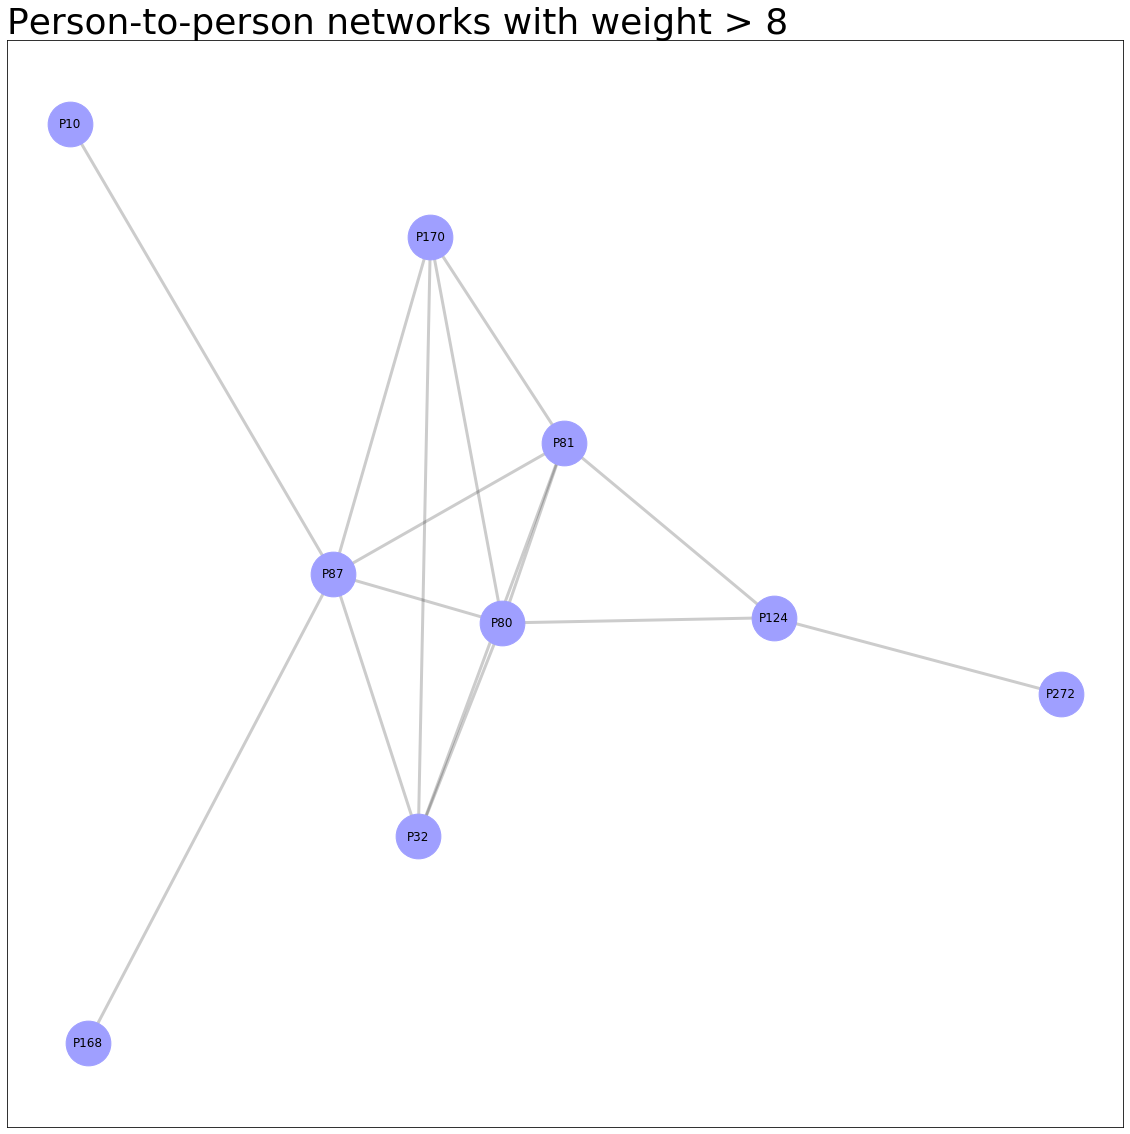

In [57]:
# Graph of islands [8 9 1]
ig = islands[1][1]
plot_person_node_graph(ig, fig_sz=(20,20))
ttl = plt.title('Person-to-person networks with weight > 8', loc = 'left', fontsize = 36)

We can see that the P87 is connected with P80, P32, P170 and P81. P124 and P272 are outside the island and connected to each other.

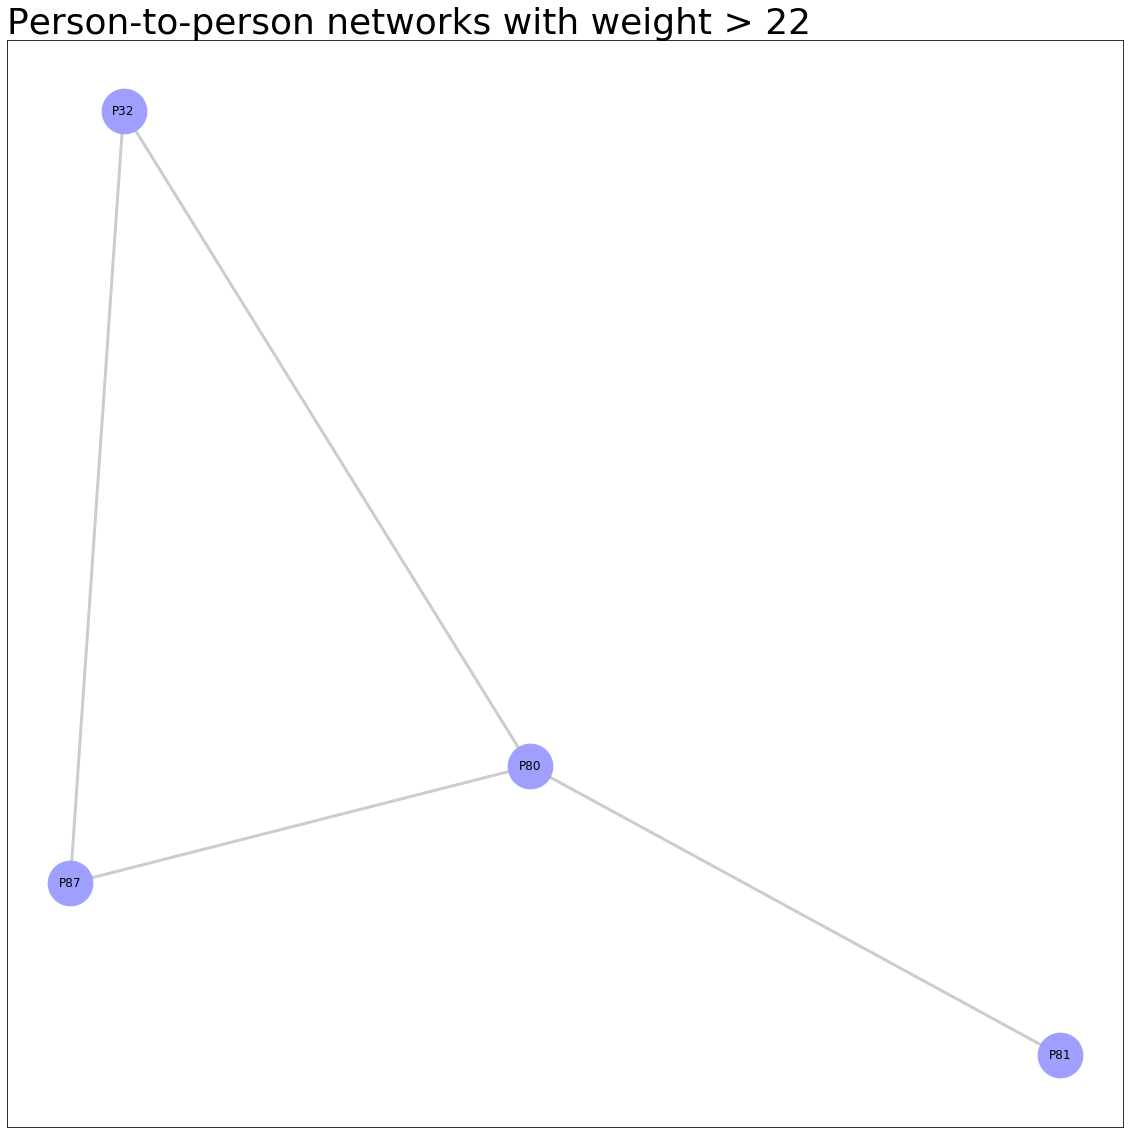

In [58]:
# Graph of islands [22 4 1]
ig = islands[3][1]
plot_person_node_graph(ig, fig_sz=(20,20))
ttl = plt.title('Person-to-person networks with weight > 22', loc = 'left', fontsize = 36)

Looking at the people that has weight above 22, we can see it is much smaller triangle. P80(possibly Hillary Clinton) is in the center and connected to P87 and P32 and P81 the strongest. Now, Let's look at who these people are.

In [59]:
P81 = dfp.query('Id == 81')
P80 = dfp.query('Id == 80')
P272 = dfp.query('Id == 272')
P87 = dfp.query('Id == 87')
P180 = dfp.query('Id == 180')
P32 = dfp.query('Id == 32')

In [60]:
people_of_interest = [P81, P80, P272, P87, P180, P32]
people_of_interest = pd.concat(people_of_interest)

In [61]:
people_of_interest

Id                Name
80    81         Huma Abedin
79    80     Hillary Clinton
271  272  valmorou@state.gov
86    87       Jake Sullivan
179  180       Richard Verma
31    32        Cheryl Mills

We can see the top people Hillary Clinton is connected to that has the most importance in the email contacts besides herself are, Huma Abedin, Jake Sullivan, Richard Verma and Cheryl Mills.

Now Let's start examining the emails. First let's do a little cleanup of the df_emails dataframe we created earlier.

In [62]:
#adjust emails dataset to add timestamp on the emails
timeStamp_split = df_emails['MetadataDateSent'].str.split("T")
Times = timeStamp_split.str[1]

df_emails['Dates'] = timeStamp_split.str[0]
df_emails['Times'] = Times.str.split("+").str[0]

df_emails['Dates'] = pd.Series(df_emails['Dates'])
df_emails['Times'] = pd.Series(df_emails['Times'])

df_emails_new = df_emails[["MetadataSubject", "ExtractedBodyText", "MetadataTo", "MetadataFrom","Times","Dates"]]
df_emails_new.columns=["Subject", "BodyText", "To", "From", "Times", "Dates"]
df_emails_new.drop(columns=['Times'], inplace=True) #dont need times only dates
df_emails_new.head()

Subject  \
0                                                WOW   
1  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   
2                                      CHRIS STEVENS   
3                         CAIRO CONDEMNATION - FINAL   
4  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   

                                            BodyText            To  \
0                                                NaN             H   
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...             H   
2                                                Thx            ;H   
3                                                NaN             H   
4  H <hrod17@clintonemail.com>\nFriday, March 11,...  Abedin, Huma   

                From       Dates  
0  Sullivan, Jacob J  2012-09-12  
1                NaN  2011-03-03  
2    Mills, Cheryl D  2012-09-12  
3    Mills, Cheryl D  2012-09-12  
4                  H  2011-03-11

In [63]:
len(df_emails_new)

7945

We see that there are total of 7,945 emails. Let's look at the top 20 peoples in the email.

In [64]:
df_emails_new['To'].value_counts()[0:20] #generate top 20 people email sent to (excluding hillary)

H                       5370
abedinh@state.gov        337
millscd@state.gov        311
sullivanjj@state.gov     297
JilotyLC@state.gov       231
ValmoroLJ@state.gov      141
Abedin, Huma              77
preines                   58
sbwhoeop                  48
Hillary                   43
cheryl.mills              38
hanleymr@state.gov        34
H2                        33
Mills, Cheryl D           32
vermarr@state.gov         30
slaughtera@state.gov      29
Russorv@state.gov         26
Sullivan, Jacob J         24
muscatinel@state.gov      18
Flores, Oscar             18
Name: To, dtype: int64

Based on the emails we can see that the top 20 people email sent to maps to the top connections we saw at the network analysis.

In [65]:
df_emails_new['From'].value_counts()[0:20] #generate top 20 persons emails (exluding hillary)

H                          1906
Abedin, Huma               1380
Mills, Cheryl D            1146
Sullivan, Jacob J           750
sbwhoeop                    316
Jiloty, Lauren C            302
Valmoro, Lona J             146
Slaughter, Anne-Marie       127
Verma, Richard R            115
PIR                         108
McHale, Judith A             73
hrod17@clintonemail.com      71
Muscatine, Lissa             70
MillsCD@state.gov            64
Verveer, Melanne S           59
AbedinH@state.gov            49
Mills, Cheryl                46
cheryl.mills                 44
Sid                          43
jake.sullivan                38
Name: From, dtype: int64

We can see the same above.

Let's further look at the times these emails are generated. To see around when the communication was the highest.

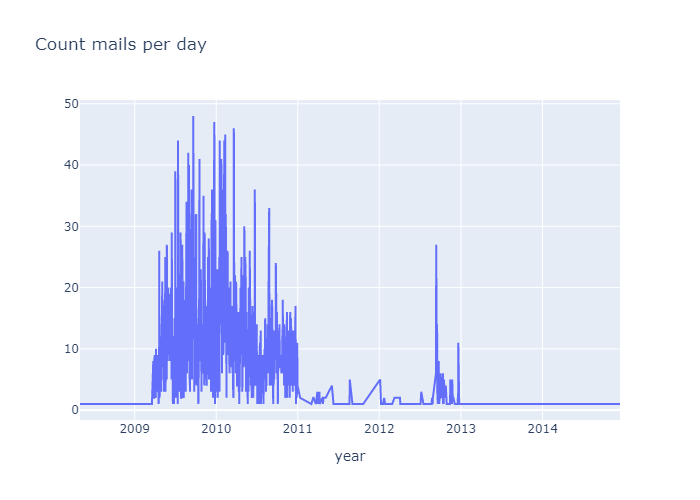

In [66]:
countDates = df_emails_new.Dates.groupby([df_emails_new.Dates]).agg(['count'])
type(countDates)
list(countDates)
countDates2= [go.Scatter(x = list(countDates.index), y=countDates['count'])]

layout = dict(title = 'Count mails per day',
              xaxis= dict(title= 'year',ticklen= 10,zeroline= False)
             )
fig = dict(data = countDates2, layout = layout)
plotly.offline.iplot(fig)
Image(pio.to_image(fig, format='png'))

We see that the communication is heavy between the contacts between 2009 and 2011 and goes down in the year of 2012 and further goes up around the end of 2012.

Let's analyze the text that are on the Subject and Body Text of the emails. Let's look at word frequency and the words that are used on both Subject and Body Text of the emails.

In [67]:
# create a function that can plot the wordcloud
def show_wordcloud_1(data, title):
    text = ' '.join(data['BodyText'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS) # we need to set the stopwords
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(15,10), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

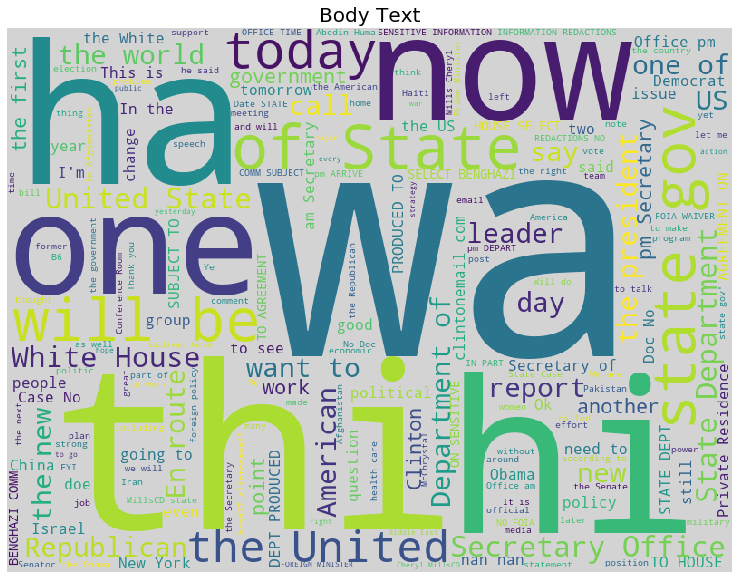

In [68]:
show_wordcloud_1(df_emails_new, "Body Text")

When we look at the body text, we see words such as "White House secretary of", "state", "gov" , "now" and "the president"

In [69]:
# create a function that can plot the wordcloud
def show_wordcloud_2(data, title):
    text = ' '.join(data['Subject'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS) # we need to set the stopwords
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(15,10), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

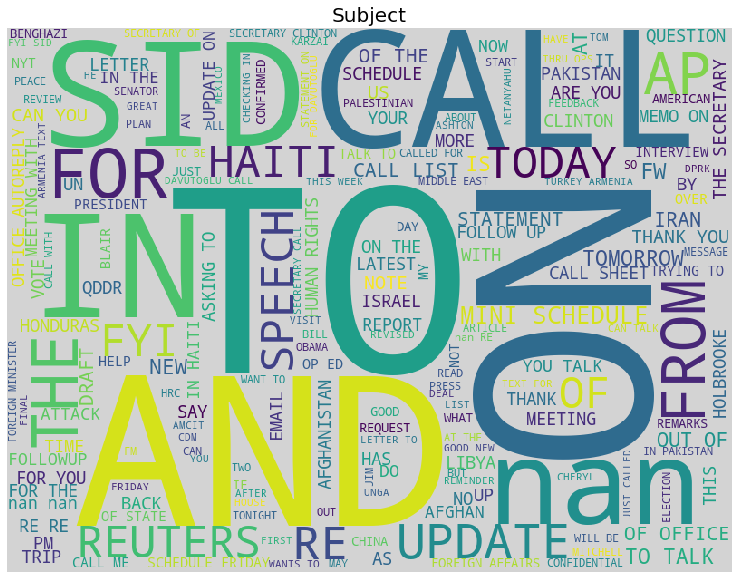

In [70]:
show_wordcloud_2(df_emails_new, "Subject")

Looking at the Subject text, we see "Reuters", "Call List", "Thank You", "on", "speech" are some of the words that stands out.

In [71]:
# to remove punctuation and stopwords we need to convert to dtype to string
df_emails_new["BodyText"]=df_emails_new["BodyText"].astype("str")
df_emails_new["Subject"]=df_emails_new["Subject"].astype("str")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
# create a function to remove punctuation and stop words
def remove_punctuation_and_stopwords(text):
    
    text_no_punctuation = [ch for ch in text if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()
    
    text_no_punctuation_no_stopwords = \
        [word.lower() for word in text_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return text_no_punctuation_no_stopwords

In [73]:
# create the list of subject and body text words
df_emails_new.loc[:, 'BodyText'] = df_emails_new['BodyText'].apply(remove_punctuation_and_stopwords)
words_body_text = df_emails_new['BodyText'].tolist()
df_emails_new.loc[:, 'Subject'] = df_emails_new['Subject'].apply(remove_punctuation_and_stopwords)
words_subject_text = df_emails_new['Subject'].tolist()
list_body_words = []
for sublist in words_body_text:
    for item in sublist:
        list_body_words.append(item)
list_subject_words = []
for sublist in words_subject_text:
    for item in sublist:
        list_subject_words.append(item)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



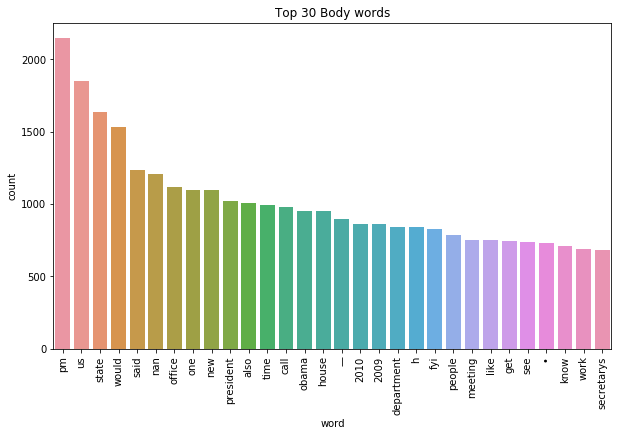

In [74]:
# frequency Dist
fdist_body  = nltk.FreqDist(list_body_words)
fdist_subject = nltk.FreqDist(list_subject_words)
# top 30 dataframe
df_body_top30_nltk  = pd.DataFrame(fdist_body.most_common(30),  columns=['word', 'count'])
df_subject_top30_nltk = pd.DataFrame(fdist_subject.most_common(30), columns=['word', 'count'])
# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_body_top30_nltk, ax=ax)
plt.title("Top 30 Body words")
plt.xticks(rotation='vertical');

Based on the frequency distribution, we see that the top 30 body words are "pm", "us", "state", "would", "said", and interstingly "ran", "office". 

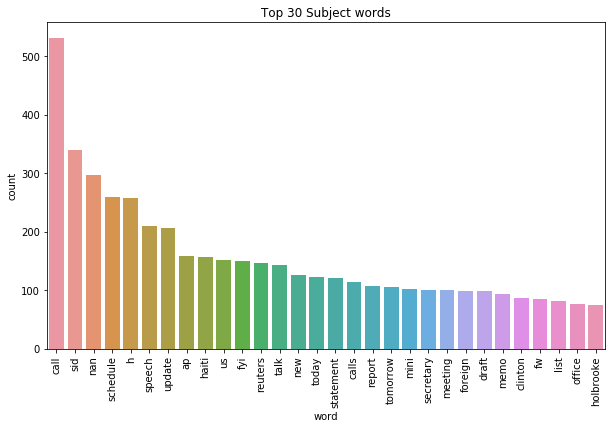

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_subject_top30_nltk, ax=ax)
plt.title("Top 30 Subject words")
plt.xticks(rotation='vertical');

Top 30 frequently used words in the Subject line of the email are "Call", "schedule", "speech", and "update"

We analyzed the emails and found relationship between the contacts, along with the most communicated people. We also looked at the top frequently used words in the Subject and Body emails. Let's further see if we can look at the topics that are in the Subject Line of the emails.

In [76]:
data = df_emails_new[pd.notnull(df_emails_new['Subject'])]
data["Subject"]=data["Subject"].astype("str")
tokenizer = RegexpTokenizer(r'\w+')
texts = [tokenizer.tokenize(email.lower()) for email in data['Subject']]

In [77]:
def delete_stopwords(tokenized_sentence: list):
    return list(filter(lambda x: x not in stop_words, tokenized_sentence))

In [78]:
stop_words = set(stopwords.words('english'))
texts = list(filter(lambda x: len(x) > 5, [delete_stopwords(text) for text in texts]))
corpora_dict = corpora.Dictionary(texts)
#corpora_dict.filter_extremes(no_below=5, no_above=0.5)
corpus = [corpora_dict.doc2bow(text) for text in texts]

In [79]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [80]:
# Human readable format of corpus (term-frequency)
[[(corpora_dict[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aiding', 1),
  ('h', 1),
  ('latest', 1),
  ('qaddafi', 1),
  ('sid', 1),
  ('syria', 1)]]

In [81]:
model_lda = LdaModel(corpus, passes=20, num_topics=10, id2word=corpora_dict)

In [82]:
str_topics = [topic_w for topic_number, topic_w in model_lda.print_topics()]
str_topics_split = list(map(lambda x: x.split("+"), str_topics))
str_topics_split = [list(map(lambda x: x.split("*")[1].strip()[1:-1], elem)) for elem in str_topics_split]

for topic in str_topics_split:
    print(topic)

['reuters', 'sid', 'h', 'global', 'haiti', 'seen', 'clinton', 'talks', 'august', 'saudi']
['ap', 'talks', 'reuters', 'israel', 'peace', 'us', 'israeli', 'settlement', 'says', 'new']
['us', 'ap', 'daily', 'minister', 'honduras', 'session', 'rights', 'trip', 'press', 'united']
['sid', 'h', 'new', 'fyi', 'budget', 'call', 'attack', 'libya', 'reuters', 'prince']
['reuters', 'us', 'pakistan', 'fax', 'ap', 'secretary', 'aid', 'clinton', 'cheryl', 'little']
['conference', 'haiti', 'call', 'pm', 'ashton', 'w', '2010', 'meeting', 'request', 'friends']
['sid', 'h', 'call', 'memo', 'talk', 'u', 'ops', 'intel', 'latest', 'election']
['h', 'sid', 'fyi', 'us', 'foreign', 'leader', 'haiti', 'law', 'report', 'front']
['call', 'foreign', 'minister', 'clinton', 'secretarys', 'secretary', 'state', 'hillary', 'rodham', 'affairs']
['foreign', 'reuters', 'us', 'ap', 'haiti', 'call', 'media', 'monday', 'diplomacy', '26']


In [83]:
data_lda = pyLDAvis.gensim.prepare(model_lda, corpus, corpora_dict)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [84]:
pyLDAvis.enable_notebook()

In [85]:
pyLDAvis.display(data_lda)

## Conclusion

We performed exploratory analysis on Hillary Clinton's email dataset and got interesting insights from the data. We plotted the weighted and unweighted Network and identified the top 10 people with the highest degree centrality. Island graphs of highest weight confirmed the highest importance individuals in the dataset. We also identified the contacts sending and receiving the highest quantity of emails and the timeframe the majority of the emails were sent during (2009-2011). Then, we performed analysis on the body and subject text of the email - we created word clouds and histograms to identify most frequently used words. Finally, we explored the topics in the Subject line of the emails and created an interactive graph for topics and relevant terms for each of those. Originally we were concerned that the network graphs will not be very insightful since this is an email network centered around Hillary Clinton, but that was not an issue since we were able to point out highest influence individuals in her circle. Nothing in our Text analysis has revealed any dubious words, themes, or interactions.

#### References:

- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

- https://medium.com/datadriveninvestor/nlp-with-lda-analyzing-topics-in-the-enron-email-dataset-20326b7ae36f